# Parameters estimation
Based on data collected from the watchtower finds the best parameters for the model of the real duckiebot

In [203]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

In [204]:
import json
with open("./data_collection.json") as f:
    data = json.loads(f.read())
print("Robot: ", data["duck"])
map_data = data["map_data"]
data = data["data"]

Robot:  DUCKVADER


In [205]:
df = pd.DataFrame(data)
df = df.set_index("sample")
df

,Positions,Inputs,Notes
sample,,,
Left circle,"[[0.5828549931435344, 2.260032743558054, -1.50...","[[0.12, 0.4], [0.12, 0.4], [0.12, 0.4], [0.12,...",Angular speed is wrong
Straight,"[[0.31610534813331903, 2.9663534569084686, -0....","[[0.4, 0.4], [0.4, 0.4], [0.4, 0.4], [0.4, 0.4...",None
Back,"[[1.527203050216432, 1.130807079190915, -1.111...","[[-0.5, -0.5], [-0.5, -0.5], [-0.5, -0.5], [-0...",None
Right circle,"[[1.1846456511238752, 2.7809238853907283, -0.9...","[[0.5, 0.15], [0.5, 0.15], [0.5, 0.15], [0.5, ...",None
Straight line calibrated,"[[0.29815961535562246, 2.979839822281533, -1.5...","[[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5...",None
Left circle calibrated,"[[1.064313836164062, 1.6532245944953257, 0.038...","[[0.15, 0.5], [0.15, 0.5], [0.15, 0.5], [0.15,...",None
Right circle calibrated,"[[1.094857572670193, 2.517572183283877, 0.2655...","[[0.5, 0.15], [0.5, 0.15], [0.5, 0.15], [0.5, ...",None
Backward calibrated,"[[0.6732136774254198, 0.857132173006317, -1.49...","[[-0.5, -0.5], [-0.5, -0.5], [-0.5, -0.5], [-0...",None


### The model:

In [206]:
MPC_TIME = 0.1
def F(action, x0, y0, theta0, u1=5, u2=0, u3=0, w1=4, w2=0, w3=0, u_alpha_r=1.5, u_alpha_l=1.5, w_alpha_r=15, w_alpha_l=15, v0=0, w0=0, dt=MPC_TIME):
    # wr, wl
    U = np.array([action[1], action[0]])
    V = U.reshape(U.size, 1)
    V = np.clip(V, -1, +1)

    ## Calculate Dynamics
    # nonlinear Dynamics - autonomous response
    f_dynamic = np.array([[-u1*v0 - u2*w0 + u3*w0**2], [-w1*w0 - w2*v0 - w3*v0*w0]])  
    #input Matrix
    B = np.array([[u_alpha_r, u_alpha_l], [w_alpha_r, -w_alpha_l]])
    # forced response
    f_forced = np.matmul(B, V)
    # acceleration
    x_dot_dot, w_dot_dot = f_dynamic + f_forced

    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return x1, y1, theta1, v1, w1

## Estimation

### Using coordinates x and y
 Estimate parameters minimizing the error between estimated and real coordinates x and y

In [207]:
idx = [4,5,6,7]
def fun(x0_opt, idxs=idx):
    """
    Returns the mse between the actual and the estimated positions
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    positions = []
    target = []
    for idx in idxs:
        target.append(np.array(data[idx]["Positions"])[:,:2])
        x0, y0, theta0 = np.array(data[idx]["Positions"])[0,:3]
        v0, w0 = 0, 0
        positions.append([x0, y0])
        action = data[idx]["Inputs"][0]
        for _ in range(target[-1].shape[0]-1):
            x0, y0, theta0, v0, w0 = F(action, x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0)
            positions.append([x0,y0])
    target = np.vstack(target)
    mse = np.square((positions - target)).mean()
    return mse

def fun_return_positions(x0_opt, idxs=idx):
    """
    Same as fun but returns a list of positions ("partials") easy to plot, keeping fun as fast as needed.
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    partials = []
    target = []
    for idx in idxs:
        target.append(np.array(data[idx]["Positions"])[:,:2])
        x0, y0, theta0 = np.array(data[idx]["Positions"])[0,:3]
        v0, w0 = 0, 0
        partial = [[x0, y0, theta0, v0, w0]]
        action = data[idx]["Inputs"][0]
        for _ in range(target[-1].shape[0]):
            x0, y0, theta0, v0, w0 = F(action, x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0)
            partial.append([x0, y0, theta0, v0, w0])
        partials.append(partial)
    return partials

In [208]:
x0 = np.ones(10)
bnds = [[0,30]]*10
res = optimize.minimize(fun, x0, method="SLSQP", bounds=bnds)
res

     fun: 0.007863022823765308
     jac: array([ 4.77624591e-04, -1.18193799e-04,  3.10244178e-03, -1.65669713e-04,
       -2.73835845e-04, -1.64132216e-04, -2.48099561e-04, -2.93141929e-05,
       -1.71229476e-05,  3.70606547e-04])
 message: 'Optimization terminated successfully'
    nfev: 388
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([4.3123709 , 0.42117578, 0.        , 1.34991163, 0.66724572,
       0.74908594, 2.27306332, 0.73258966, 3.12010274, 2.86162447])

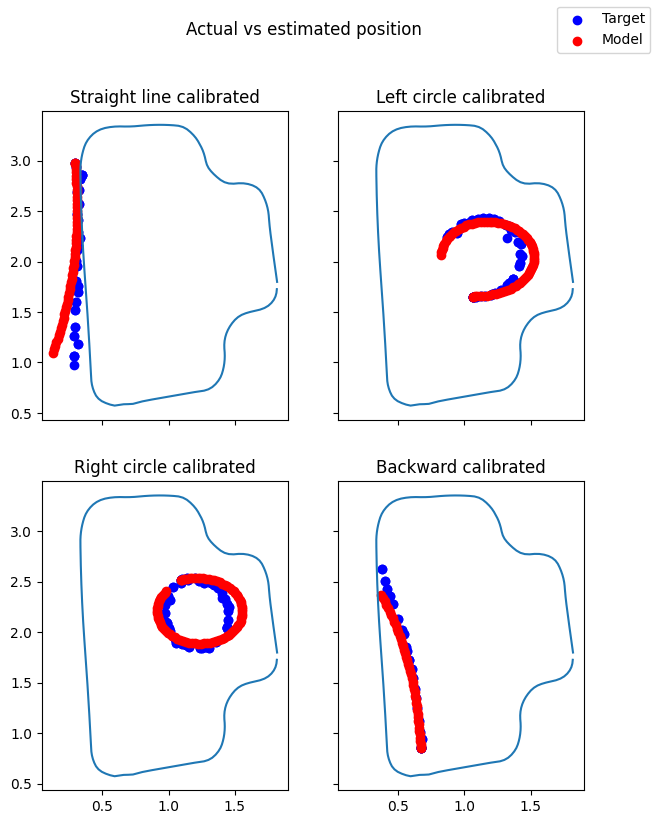

In [209]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target.T, c="b", label="Target")
    ax.scatter(*np.array(position)[:,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

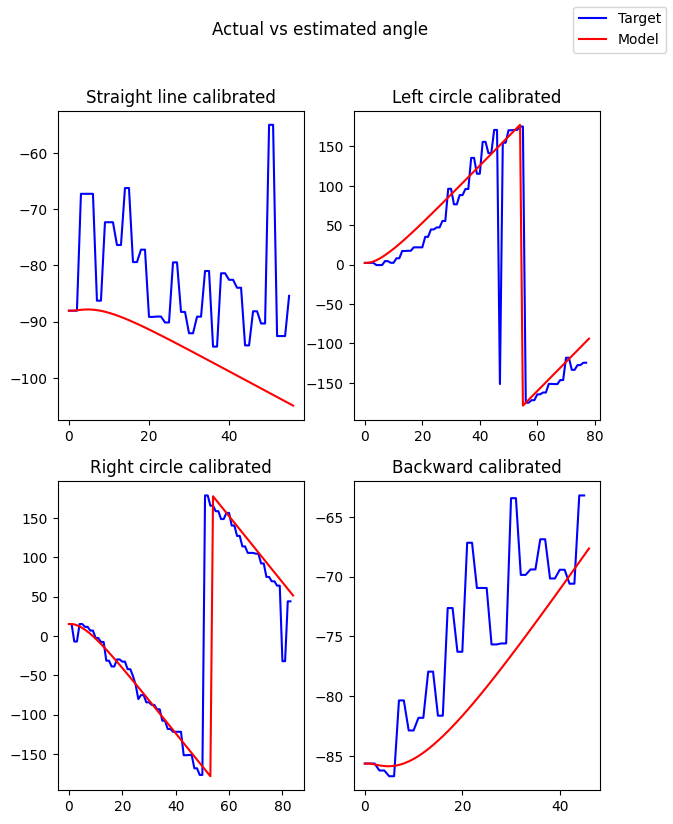

In [210]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated angle")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.rad2deg(np.array(data[idx_]["Positions"])[:,2])
    train = np.array(position)[:,2]
    train = np.mod(train+np.pi, 2*np.pi)-np.pi
    ax.plot(target, c="b", label="Target")
    ax.plot(np.rad2deg(train), c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

In [211]:
linear_speeds = []
angular_speeds = []
estimated = True
if estimated:
    for poses in positions:
        poses = np.array(poses)
        linear_speed = np.sqrt(np.square(poses[1:, :2] - poses[:-1, :2]).sum(axis=1))/MPC_TIME
        linear_speeds.append(linear_speed)
        angular_speed = (poses[1:, 2] - poses[:-1, 2])/MPC_TIME
        angular_speeds.append(angular_speed)
else:
    target = [data[idx_]["Positions"] for idx in idx]
    for poses in target:
        poses = np.array(poses)
        linear_speed = np.sqrt(np.square(poses[1:, :2] - poses[:-1, :2]).sum(axis=1))/MPC_TIME
        linear_speed = np.cumsum(linear_speed, dtype=float)
        linear_speed[5:] = linear_speed[5:] - linear_speed[:-5]
        linear_speeds.append(linear_speed/5)
        angular_speed = (poses[1:, 2] - poses[:-1, 2])/MPC_TIME
        angular_speeds.append(angular_speed)
linear_speeds[-1] *= -1

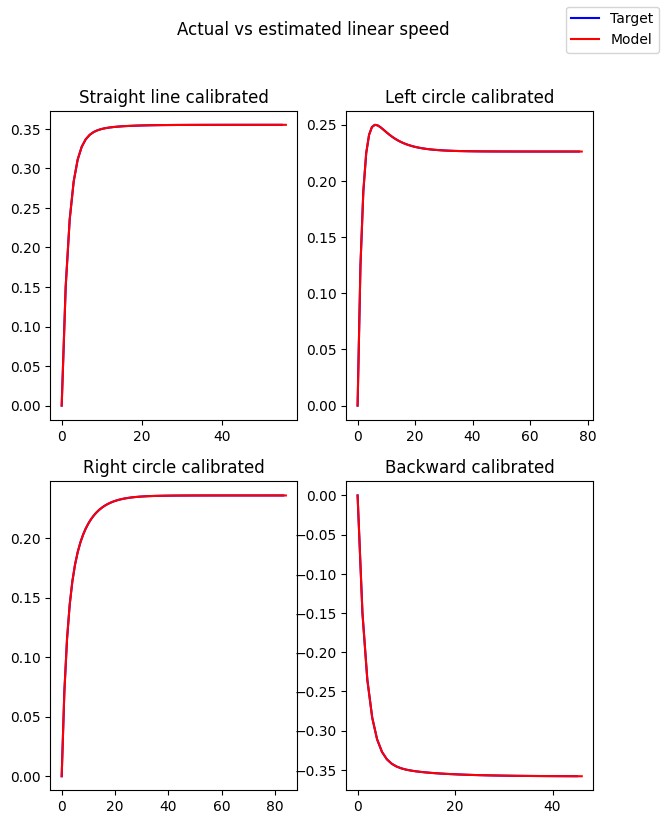

In [212]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated linear speed")
for idx_, ax, position, linear_speed in zip(idx, axs.reshape(-1), positions, linear_speeds):
    target = linear_speed
    train = np.array(position)[:,3]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

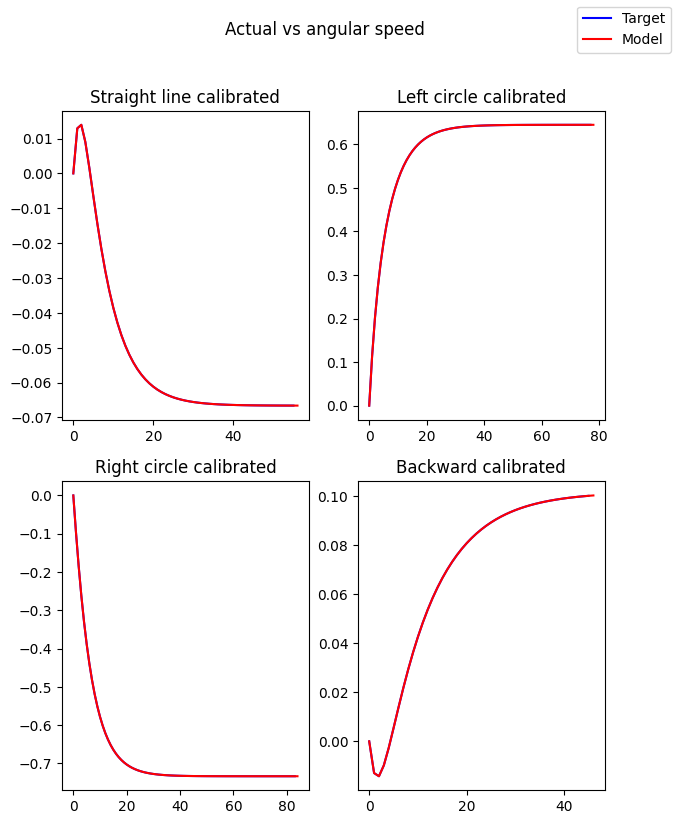

In [213]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs angular speed")
for idx_, ax, position, angular_speed in zip(idx, axs.reshape(-1), positions, angular_speeds):
    target = angular_speed
    train = np.array(position)[:,4]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

The speeds make a lot of sense.

## Using linear and angular speed
Assuming the previous positions to be correct use them to compute the speed and rebuild the loss function to minimize the error wrt the speed

In [214]:
def fun(x0_opt, idxs=idx):
    """
    Returns the mse between the predicted angles and the actual angles
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    speeds = []
    target = np.vstack((np.hstack(linear_speeds), np.hstack(angular_speeds))).T
    for idx in idxs:
        elements = np.array(data[idx]["Positions"])
        x0, y0, theta0 = elements[0,:3]
        v0, w0 = 0, 0
        positions.append([v0, w0])
        action = data[idx]["Inputs"][0]
        for _ in range(elements.shape[0]):
            x0, y0, theta0, v0, w0 = F(action, x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0, dt=MPC_TIME)
            speeds.append([v0,w0])
    mse = np.square((speeds - target)).mean()
    return mse

In [215]:
x0 = np.ones(10)
bnds = [[0,30]]*10
res = optimize.minimize(fun, x0, method="SLSQP", bounds=bnds)
res

     fun: 0.00019753272428813047
     jac: array([ 1.79171475e-05, -5.60798071e-06,  4.72540705e-07, -6.47977377e-05,
       -1.62506551e-04,  9.30646420e-05, -1.99243974e-04, -6.42544383e-05,
        2.66326520e-04, -1.72891616e-04])
 message: 'Optimization terminated successfully'
    nfev: 387
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([2.51722446e+00, 3.47399623e-02, 8.67361738e-19, 9.93628279e-01,
       3.20764455e-01, 1.15551145e+00, 9.67476071e-01, 8.31182119e-01,
       2.52811320e+00, 2.45966952e+00])

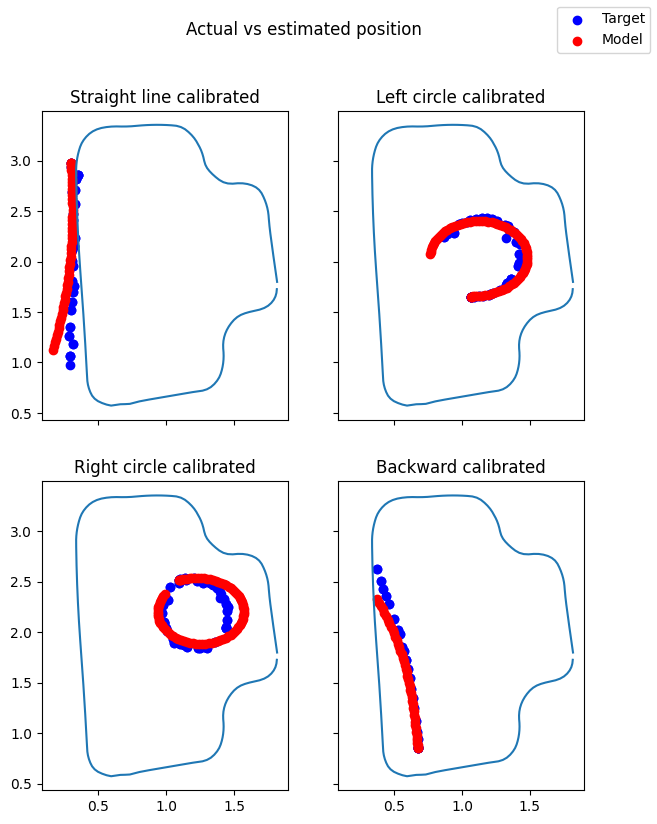

In [216]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target.T, c="b", label="Target")
    ax.scatter(*np.array(position)[:,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

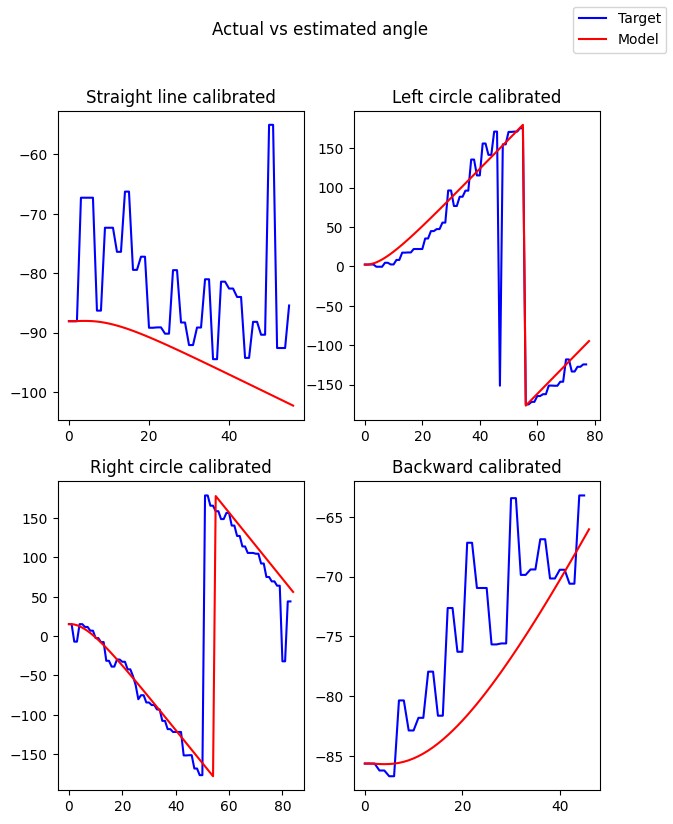

In [217]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated angle")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.rad2deg(np.array(data[idx_]["Positions"])[:,2])
    train = np.array(position)[:,2]
    train = np.mod(train+np.pi, 2*np.pi)-np.pi
    ax.plot(target, c="b", label="Target")
    ax.plot(np.rad2deg(train), c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

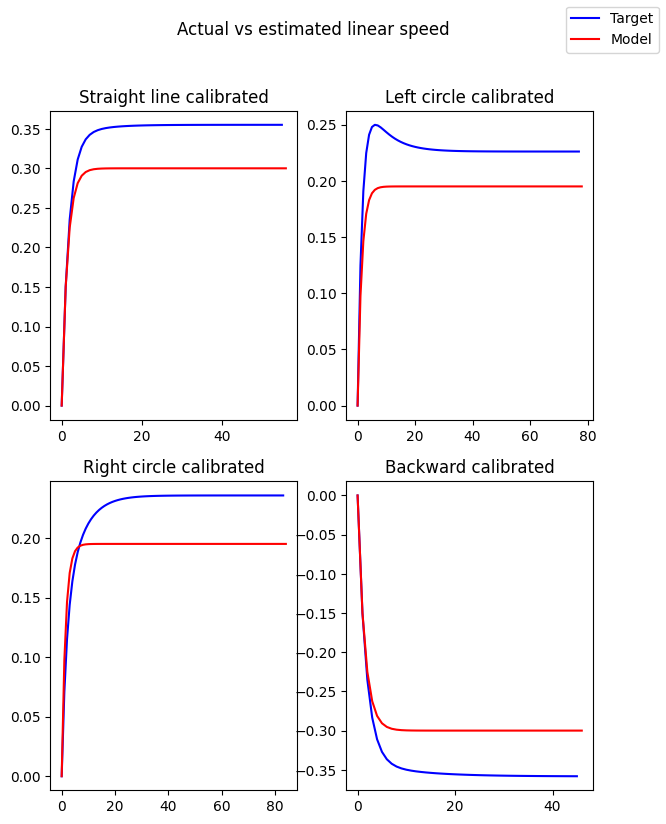

In [218]:
positions = fun_return_positions([5,0,0,4,0,0,1.5,1.5,15,15])
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated linear speed")
for idx_, ax, position, linear_speed in zip(idx, axs.reshape(-1), positions, linear_speeds):
    target = linear_speed
    train = np.array(position)[:,3]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

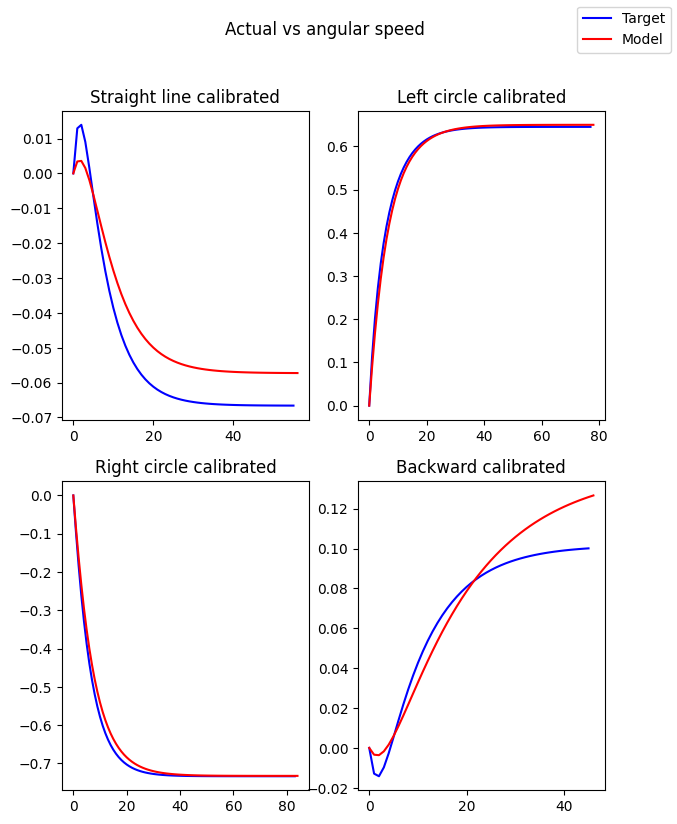

In [219]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs angular speed")
for idx_, ax, position, angular_speed in zip(idx, axs.reshape(-1), positions, angular_speeds):
    target = angular_speed
    train = np.array(position)[:,4]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")